In [ ]:
from IPython.display import clear_output

## Task: Predict the median value of houses of california houses using NN (regression)

You are provided with the code to load california housing dataset.

The dataset contains the following features about houses.

- MedInc (Median Income): Median income for households within a district.
- HouseAge: Median age of housing in the district.
- AveRooms: Average rooms per household.
- AveBedrms: Average bedrooms per household.
- Population: Total population in the district.
- AveOccup: Average household occupancy.
- Latitude: Latitude coordinate for the district.
- Longitude: Longitude coordinate for the district.

As for the predicted values, the target is median values of the houses.

Your task is to train a **Neural Network** which takes the features about a house and output it's median value.

Make sure to put emphasis on code quality and to include a measure of how well your final model is performing on untrained data.

In [ ]:
from datetime import datetime
import random

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torch.optim import Adam

from torchsummary import summary

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import matplotlib.pyplot as plt

import plotly
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots

import seaborn as sns

In [ ]:
# Load the California housing dataset

housing = fetch_california_housing()

In [ ]:
# Sanity check for data completeness

df = pd.DataFrame(housing.data, columns=housing.feature_names)
print(f"Lenght df: {len(df)}")
# Calculate the number of NaN values in each column
nan_counts = df.isna().sum()
print(nan_counts)

Lenght df: 20640
MedInc        0
HouseAge      0
AveRooms      0
AveBedrms     0
Population    0
AveOccup      0
Latitude      0
Longitude     0
dtype: int64


In [ ]:
# Data Preprocessing

# Split into features and targets
X, y = housing.data, housing.target

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler_X = StandardScaler()
X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)

# Not scaling the target this time

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)  # unsqueeze to make it (batch_size, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

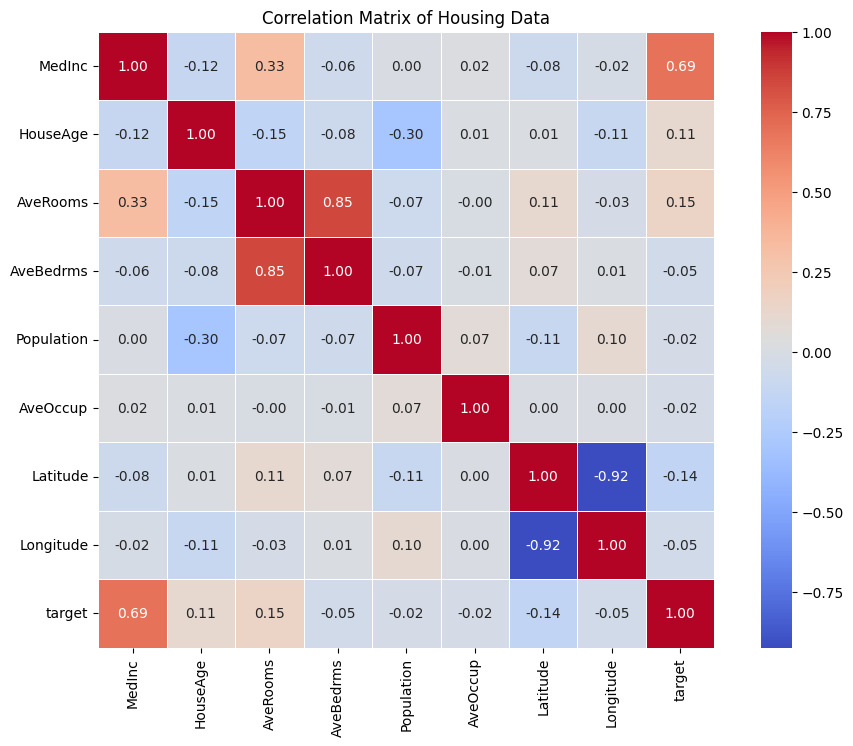

In [ ]:
# Creating a correlation matrix to see how each feature influences another

# Combining the data into a single DataFrame
data = np.column_stack((X, y))
columns = list(housing.feature_names) + ['target']
df = pd.DataFrame(data, columns=columns)

# Calculating the correlation matrix
correlation_matrix = df.corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 8))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True, linewidths=.5)

# Title and display the plot
plt.title('Correlation Matrix of Housing Data')
plt.show()


In [ ]:
# Creating custom dataset class to use torch data loader

class CaliforniaHousingDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create datasets
train_dataset = CaliforniaHousingDataset(X_train_tensor, y_train_tensor)
test_dataset = CaliforniaHousingDataset(X_test_tensor, y_test_tensor)

In [ ]:
# Split data into batches

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, drop_last=True) # drop_last = drops last batch if length not equal to batch size
test_loader = DataLoader(test_dataset, batch_size=batch_size)

print(f"Size train data: {len(train_dataset)} entries in {len(train_loader)} batches.")
print(f"Size test data: {len(test_dataset)} entries in {len(test_loader)} batches!")

Size train data: 16512 entries in 258 batches.
Size test data: 4128 entries in 65 batches!


In [ ]:
# Set device type on which computation will be performed

device = "cpu" # default to cpu

if torch.cuda.is_available():
  device = "cuda"

print(f"Using device: {device}")

Using device: cpu


# Implementation with pytorch (Object oriented way)

In [ ]:
# Creating my neural network

class Housing_NN(nn.Module):
  def __init__(self, ni, h1,h2, no):
    super().__init__()
    self.layer_one = nn.Linear(ni, h1)
    self.layer_two = nn.Linear(h1, h2)
    self.layer_three = nn.Linear(h2, no)

    self.hidden_activation = nn.ReLU()

  def forward(self, x):
    z1 = self.layer_one(x)
    a1 = self.hidden_activation(z1)

    z2 = self.layer_two(a1)
    a2 = self.hidden_activation(z2)

    z3 = self.layer_three(a2)

    return z3

In [ ]:
# Setting up the model with its params

# reference for the model
model = Housing_NN(8, 64, 32, 1)

# Learning rate
lr = 0.004

optimizer = Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss() # using mean squeared error, since it is an regression problem

model.to(device) # send model to device

Housing_NN(
  (layer_one): Linear(in_features=8, out_features=64, bias=True)
  (layer_two): Linear(in_features=64, out_features=32, bias=True)
  (layer_three): Linear(in_features=32, out_features=1, bias=True)
  (hidden_activation): ReLU()
)

In [ ]:
# Check model parameters (2,689 in total)

summary(model, (8,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 64]             576
              ReLU-2                   [-1, 64]               0
            Linear-3                   [-1, 32]           2,080
              ReLU-4                   [-1, 32]               0
            Linear-5                    [-1, 1]              33
Total params: 2,689
Trainable params: 2,689
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.01
----------------------------------------------------------------


In [ ]:
# Train and evaluate model (alternating)

# Lists to store losses
train_losses = []
val_losses = []

# Training loop
epochs = 100
for epoch in range(epochs):
    # Training phase
    model.train() # set model to train mode
    running_train_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()           # Zero the gradients
        outputs = model(inputs)         # Forward pass
        loss = criterion(outputs, targets)  # Calculate loss
        loss.backward()                 # Backward pass
        optimizer.step()                # Update weights
        running_train_loss += loss.item()

    train_losses.append(running_train_loss / len(train_loader))  # Store average training loss

    # Evaluation phase
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_val_loss += loss.item()

    val_losses.append(running_val_loss / len(test_loader))  # Store average validation loss


    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

Epoch 1/100, Train Loss: 0.6878, Val Loss: 0.4157
Epoch 2/100, Train Loss: 0.3795, Val Loss: 0.3741
Epoch 3/100, Train Loss: 0.3526, Val Loss: 0.3559
Epoch 4/100, Train Loss: 0.3414, Val Loss: 0.3433
Epoch 5/100, Train Loss: 0.3295, Val Loss: 0.3334
Epoch 6/100, Train Loss: 0.3231, Val Loss: 0.3258
Epoch 7/100, Train Loss: 0.3139, Val Loss: 0.3208
Epoch 8/100, Train Loss: 0.3091, Val Loss: 0.3170
Epoch 9/100, Train Loss: 0.3052, Val Loss: 0.3154
Epoch 10/100, Train Loss: 0.3023, Val Loss: 0.3107
Epoch 11/100, Train Loss: 0.2993, Val Loss: 0.3093
Epoch 12/100, Train Loss: 0.2998, Val Loss: 0.3085
Epoch 13/100, Train Loss: 0.2958, Val Loss: 0.3090
Epoch 14/100, Train Loss: 0.2987, Val Loss: 0.3034
Epoch 15/100, Train Loss: 0.2923, Val Loss: 0.3009
Epoch 16/100, Train Loss: 0.2890, Val Loss: 0.2993
Epoch 17/100, Train Loss: 0.2934, Val Loss: 0.2979
Epoch 18/100, Train Loss: 0.2851, Val Loss: 0.2967
Epoch 19/100, Train Loss: 0.2844, Val Loss: 0.2966
Epoch 20/100, Train Loss: 0.2808, Val Lo

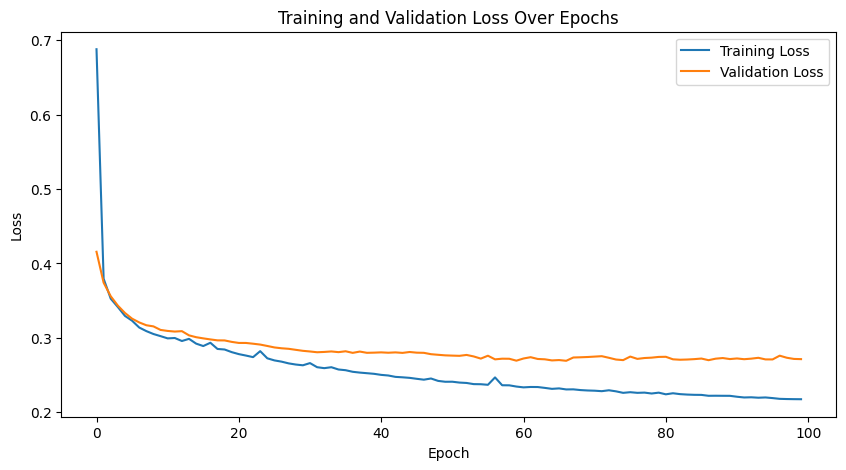

In [ ]:
# Plotting the training and validation loss

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

# Conclusion Training
The training loss converges which is good. The validation loss is stablizing after around 20-25 epochs.

This means, that further training only brings marginal better results.

Since the validation curve stays at this level, it is an indicator that the model is not overfitted. When an overfitting occurs, the curve would diverge from the training loss curve. In the other case – an underfitted model – the curve would drastically alternate between higher and lower loss values.

In [ ]:
# Model evaluation: get predictions for the test dataset

model.eval() # set model to evaluation mode
predictions = []
actuals = []
with torch.no_grad(): # used to disable gradient comuptation and unwanted training.
    for inputs, targets in test_loader:
        outputs = model(inputs)
        predictions.extend(outputs.numpy().flatten())
        actuals.extend(targets.numpy().flatten())

In [ ]:
# Create a scatter plot using Plotly which shows actual and predicted values (sorted by index)

fig = make_subplots()

# Add trace for actual values
fig.add_trace(go.Scatter(
    x=np.arange(len(actuals)),
    y=actuals,
    mode='markers',
    marker=dict(color='blue'),
    name='Actual Values',
    hovertemplate='Index: %{x}<br>Actual avg price: %{y}<extra></extra>'
))

# Add trace for predicted values (PyTorch method)
fig.add_trace(go.Scatter(
    x=np.arange(len(predictions)),
    y=predictions,
    mode='markers',
    marker=dict(color='red'),
    name='Predicted Values – PyTorch',
    hovertemplate='Index: %{x}<br>Predicted avg price: %{y}<extra></extra>'
))

# Update layout
fig.update_layout(
    title='Actual vs. Predicted Values',
    xaxis_title='Index',
    yaxis_title='Values',
    showlegend=True
)

fig.show()

In [ ]:
# Calculate residuals

# Convert lists to numpy arrays for Plotly
y_pred = np.array(predictions)
y_test = np.array(actuals)

# Calculate residuals
residuals = y_test - y_pred

In [ ]:
# Create interactive scatter plot for residuals
fig_residuals = go.Figure()

# Add trace for residuals of the custom PyTorch model
fig_residuals.add_trace(go.Scatter(
    x=np.arange(len(predictions)),  # Use index as x-axis
    y=residuals.flatten(),  # Residuals on y-axis
    mode='markers',
    marker=dict(color='blue'),
    name='Residuals (PyTorch Model)',
    hovertemplate='Index: %{x}<br>Residual: %{y}<extra></extra>',
    hoverinfo='text'
))

# Add horizontal line at y=0 for reference
fig_residuals.add_trace(go.Scatter(
    x=[0, len(residuals)-1],
    y=[0, 0],
    mode='lines',
    line=dict(color='red', width=2),
    name='Zero Residual Line'
))

# Update layout
fig_residuals.update_layout(
    title='Residuals Plot',
    xaxis_title='Index',
    yaxis_title='Residuals',
    showlegend=True
)

# Show plot
fig_residuals.show()

In [ ]:
# Create interactive distribution of residuals plot
fig_dist_residuals = go.Figure()

# Add histogram for residuals
fig_dist_residuals.add_trace(go.Histogram(
    x=residuals.flatten(),
    nbinsx=30,  # Number of bins in histogram
    marker=dict(color='blue'),
    name='Residuals Distribution',
    hovertemplate='Residuals: %{x}<br>Frequency: %{y}<extra></extra>'
))

# Update layout
fig_dist_residuals.update_layout(
    title='Distribution of Residuals',
    xaxis_title='Residuals',
    yaxis_title='Frequency',
    showlegend=True
)

# Show plot
fig_dist_residuals.show()

In [ ]:
# Calculate metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae:.4f}")
print(f"Mean Squared Error: {mse:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")
print(f"R-squared: {r2:.4f}")

Mean Absolute Error: 0.3467
Mean Squared Error: 0.2723
Root Mean Squared Error: 0.5218
R-squared: 0.7922


# Trying a premade model (xgboost) on it to compare to own results

In [ ]:
import xgboost as xgb

# Convert the data to DMatrix format for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Define the parameters for the XGBoost model
params = {
    'objective': 'reg:squarederror',  # Regression problem
    'eval_metric': 'rmse',  # Evaluation metric
    'max_depth': 6,  # Maximum depth of a tree
    'learning_rate': 0.1,  # Learning rate
    'alpha': 10  # L1 regularization term
}

# Train the XGBoost model
num_round = 100  # Number of boosting rounds
bst = xgb.train(params, dtrain, num_round)

# Make predictions on the test set
y_pred_xg = bst.predict(dtest)

# Calculate metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae:.4f}")
print(f"Mean Squared Error: {mse:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")
print(f"R-squared: {r2:.4f}")

Mean Absolute Error: 0.3219
Mean Squared Error: 0.2317
Root Mean Squared Error: 0.4813
R-squared: 0.8232


# Conlusion

My pytorch model does resonably well. The XGBoost seems to be one of the best models for this kind of predictions – atleast from the ones I tested.

Overall I would look out for the R-Squared Score. Around 0.8 looks like a reasonable result. At level of above 0.95 I would argue that the model is somewhat overfitted.

In [ ]:
# Create plot for comparison between different models (my pytorch and xgboost)

fig = make_subplots()

# Add trace for actual values
fig.add_trace(go.Scatter(
    x=np.arange(len(actuals)),
    y=actuals,
    mode='markers',
    marker=dict(color='blue'),
    name='Actual Values',
    hovertemplate='Index: %{x}<br>Actual avg price: %{y}<extra></extra>'
))

# Add trace for predicted values (PyTorch method)
fig.add_trace(go.Scatter(
    x=np.arange(len(predictions)),
    y=predictions,
    mode='markers',
    marker=dict(color='red'),
    name='Predicted Values – PyTorch',
    hovertemplate='Index: %{x}<br>Predicted avg price: %{y}<extra></extra>'
))

# Add trace for predicted values (PyTorch method)
fig.add_trace(go.Scatter(
    x=np.arange(len(predictions)),
    y=y_pred_xg,
    mode='markers',
    marker=dict(color='green'),
    name='Predicted Values – XGBoost',
    hovertemplate='Index: %{x}<br>Predicted avg price: %{y}<extra></extra>'
))

# Update layout
fig.update_layout(
    title='Actual vs. Predicted Values',
    xaxis_title='Index',
    yaxis_title='Values',
    showlegend=True
)

fig.show()